<h1><b>mobilenetV2</b></h1>

In [8]:
import pandas as pd
import numpy as np

In [9]:
import keras
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import Sequence, to_categorical
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

import matplotlib.pyplot as plt
import PIL
import cv2
import tensorflow as tf
import pandas as pd
# import imgaug as ia
import numpy as np

# from imgaug import augmenters as iaa

from PIL import Image, ImageOps
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score

<p style="color:blue"><b>START: DATA</b></p>

In [3]:
df=pd.read_csv("dataset_ten.csv")

In [4]:
df["Diagnosis"].value_counts()

0    5000
1    5000
Name: Diagnosis, dtype: int64

In [5]:
df=df.drop(labels='Unnamed: 0',axis=1)

In [6]:
df.head(n=2)

,Patient ID,Diagnosis,Pathes
0,9126,1,archive/9126/1/9126_idx5_x1901_y1951_class1.png
1,9043,1,archive/9043/1/9043_idx5_x3351_y651_class1.png


<p><b>train test split</b></p>

In [7]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df,test_size=0.3,random_state=8)

<b>load data</b>

In [8]:
df_train.to_csv("df_train.csv")

In [3]:
df_train = pd.read_csv("df_train.csv")

In [4]:
df_train.head(n=2)

,Unnamed: 0,Patient ID,Diagnosis,Pathes
0,6983,13691,1,archive/13691/1/13691_idx5_x3201_y1301_class1.png
1,63,12749,1,archive/12749/1/12749_idx5_x2601_y601_class1.png


In [5]:
df_train = df_train.drop(labels='Unnamed: 0',axis=1)

In [6]:
df_train.head(n=2)

,Patient ID,Diagnosis,Pathes
0,13691,1,archive/13691/1/13691_idx5_x3201_y1301_class1.png
1,12749,1,archive/12749/1/12749_idx5_x2601_y601_class1.png


In [9]:
df_test.to_csv("df_test_st.csv")

In [10]:
df_test , df_evaluate = train_test_split(df_test,test_size=0.3,random_state=8)

In [11]:
df_test.to_csv("df_test.csv")

In [7]:
df_test = pd.read_csv("df_test.csv")

In [8]:
df_test = df_test.drop(labels='Unnamed: 0',axis=1)

In [9]:
df_test.head(n=2)

,Patient ID,Diagnosis,Pathes
0,9324,0,archive/9324/0/9324_idx5_x1601_y1051_class0.png
1,12751,0,archive/12751/0/12751_idx5_x2451_y1101_class0.png


In [12]:
df_evaluate.to_csv("df_evaluate.csv")

In [10]:
df_evaluate = pd.read_csv("df_evaluate.csv")

In [11]:
df_evaluate = df_evaluate.drop(labels='Unnamed: 0',axis=1)

In [12]:
df_evaluate.head(n=2)

,Patient ID,Diagnosis,Pathes
0,9320,1,archive/9320/1/9320_idx5_x2151_y1951_class1.png
1,9037,0,archive/9037/0/9037_idx5_x251_y401_class0.png


In [13]:
df_test["Diagnosis"].value_counts()

0    1091
1    1009
Name: Diagnosis, dtype: int64

In [14]:
df_evaluate["Diagnosis"].value_counts()

1    452
0    448
Name: Diagnosis, dtype: int64

In [17]:
df_train.head(n=2)

,Patient ID,Diagnosis,Pathes
0,13691,1,archive/13691/1/13691_idx5_x3201_y1301_class1.png
1,12749,1,archive/12749/1/12749_idx5_x2601_y601_class1.png


In [18]:
df_test.head(n=2)

,Patient ID,Diagnosis,Pathes
0,9324,0,archive/9324/0/9324_idx5_x1601_y1051_class0.png
1,12751,0,archive/12751/0/12751_idx5_x2451_y1101_class0.png


In [19]:
df_train["Diagnosis"].value_counts()

1    3539
0    3461
Name: Diagnosis, dtype: int64

In [20]:
df_test["Diagnosis"].value_counts()

0    1091
1    1009
Name: Diagnosis, dtype: int64

In [21]:
df_evaluate["Diagnosis"].value_counts()

1    452
0    448
Name: Diagnosis, dtype: int64

<p>getting the training data from directory</p>

In [11]:
from PIL import Image
# random_train['Pixels']=np.array(random_train['Pathes'].map(lambda x:np.asarray(open(x).resize((128,128)))))
# X_train_mobilenet=df_train['Pathes'].map(lambda x:np.asarray(Image.open(x).resize((128,128))))
X_train_mobilenet=df_train['Pathes'].map(lambda x:np.asarray(Image.open(x)))


In [13]:
y_train_mobilenet = np.array(df_train['Diagnosis'])

<p style="color:blue"><b>FINISH: DATA</b></p>

<b>start: data generator</b>

In [13]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.mobilenet_v2 import preprocess_input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [14]:
BATCH_SIZE = 64
IMAGE_SIZE = (224,224)
train_batches = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)


Found 7000 validated image filenames.


In [15]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   )
test_batches = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 2100 validated image filenames.


In [16]:
valid_batches = test_datagen.flow_from_dataframe(dataframe=df_evaluate,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 900 validated image filenames.


In [17]:
from keras.models import Sequential
from keras.layers import Dense , GlobalAveragePooling2D
from keras.applications import MobileNetV2
num_classes = 1
model = Sequential([
     MobileNetV2(input_shape=(224,224,3),weights="imagenet",include_top=False), 
     GlobalAveragePooling2D(),
     Dense(num_classes, activation='sigmoid',name='preds'),
])
model.layers[0].trainable= False
# show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
preds (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        verbose=1,
    )
]

In [203]:
model.compile(optimizer='adam',
             loss=keras.losses.binary_crossentropy,
             metrics=['accuracy',metrics.Precision(),metrics.Recall(),metrics.TruePositives(),metrics.TrueNegatives(),metrics.FalsePositives(),metrics.FalseNegatives()])
trained_MobileNetV2 = model.fit_generator(train_batches,
#           validation_data=test_batches,
          validation_data=valid_batches,
          epochs=50,
#           validation_split=0.2,
          verbose=1,
          callbacks=[callbacks]
         )

Epoch 1/50
110/110 [==============================] - 323s 3s/step - loss: 0.5009 - accuracy: 0.7621 - precision_4: 0.7647 - recall_3: 0.7649 - true_positives_6: 2707.0000 - true_negatives_5: 2628.0000 - false_positives_5: 833.0000 - false_negatives_5: 832.0000 - val_loss: 0.4100 - val_accuracy: 0.8189 - val_precision_4: 0.8121 - val_recall_3: 0.8319 - val_true_positives_6: 376.0000 - val_true_negatives_5: 361.0000 - val_false_positives_5: 87.0000 - val_false_negatives_5: 76.0000
Epoch 2/50
110/110 [==============================] - 320s 3s/step - loss: 0.4467 - accuracy: 0.8053 - precision_4: 0.8053 - recall_3: 0.8110 - true_positives_6: 2870.0000 - true_negatives_5: 2767.0000 - false_positives_5: 694.0000 - false_negatives_5: 669.0000 - val_loss: 0.4020 - val_accuracy: 0.8256 - val_precision_4: 0.8345 - val_recall_3: 0.8142 - val_true_positives_6: 368.0000 - val_true_negatives_5: 375.0000 - val_false_positives_5: 73.0000 - val_false_negatives_5: 84.0000
Epoch 3/50
110/110 [==========

In [21]:
model = load_model('mobilenetV2_ten.h5')

In [22]:
model_mobilenet_score = model.evaluate(test_batches)

33/33 [==============================] - 84s 3s/step - loss: 0.4044 - accuracy: 0.8238 - precision_4: 0.7972 - recall_3: 0.8494 - true_positives_6: 857.0000 - true_negatives_5: 873.0000 - false_positives_5: 218.0000 - false_negatives_5: 152.0000


In [23]:
from sklearn.metrics import classification_report , confusion_matrix
y_pred_mobilenet_aug=model.predict_classes(test_batches)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [24]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [25]:
print(accuracy_score(y_pred_mobilenet_aug,np.array(df_test["Diagnosis"])))

0.820952380952381


In [26]:
print(recall_score(y_pred_mobilenet_aug,np.array(df_test["Diagnosis"])))

0.7960710944808232


In [27]:
print(precision_score(y_pred_mobilenet_aug,np.array(df_test["Diagnosis"])))

0.8434093161546086


In [28]:
print(f1_score(y_pred_mobilenet_aug,np.array(df_test["Diagnosis"])))

0.8190567853705487


In [218]:
y_pred_mobilenet_aug.shape

(2100, 1)

In [219]:
print(classification_report(y_pred_mobilenet_aug,np.array(df_test["Diagnosis"])))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1030
           1       0.84      0.80      0.82      1070

    accuracy                           0.82      2100
   macro avg       0.82      0.82      0.82      2100
weighted avg       0.82      0.82      0.82      2100



In [36]:
def plot_acc_loss(trained):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(trained.epoch, trained.history["loss"], label="Train loss")
    ax[0].plot(trained.epoch, trained.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(trained.epoch, trained.history["accuracy"], label="Train acc")
    ax[1].plot(trained.epoch, trained.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

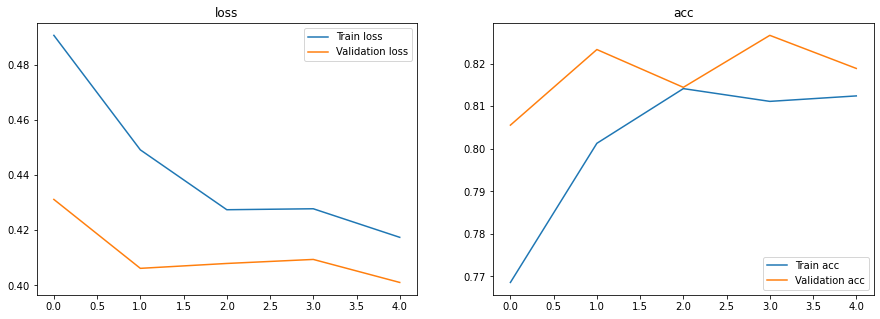

In [37]:
plot_acc_loss(trained_MobileNetV2)

In [221]:
trained_MobileNetV2.history.keys()

dict_keys(['loss', 'accuracy', 'precision_4', 'recall_3', 'true_positives_6', 'true_negatives_5', 'false_positives_5', 'false_negatives_5', 'val_loss', 'val_accuracy', 'val_precision_4', 'val_recall_3', 'val_true_positives_6', 'val_true_negatives_5', 'val_false_positives_5', 'val_false_negatives_5'])

In [220]:
model.save("mobilenetV2_ten.h5")

In [222]:
xyz=np.array(confusion_matrix(np.array(df_test["Diagnosis"]),y_pred_mobilenet_aug))

<AxesSubplot:>

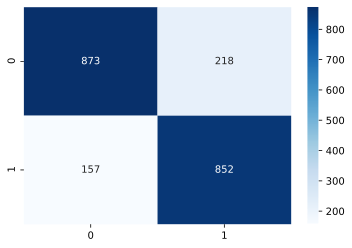

In [223]:
import seaborn as sns

# cf_matrix = np.array([[50, 2, 38],
#                       [7, 43, 32],
#                       [9,  4, 76]])

sns.heatmap(xyz, annot=True, cmap='Blues', fmt='d')

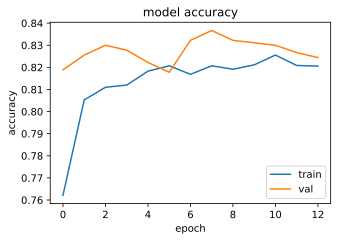

In [224]:
import keras
from matplotlib import pyplot as plt
# history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(trained_MobileNetV2.history['accuracy'])
plt.plot(trained_MobileNetV2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.subplots_adjust(bottom=.25, left=.25)
plt.show()

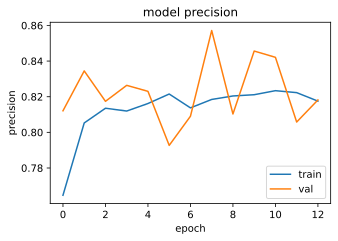

In [227]:
import keras
from matplotlib import pyplot as plt
# history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(trained_MobileNetV2.history['precision_4'])
plt.plot(trained_MobileNetV2.history['val_precision_4'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.subplots_adjust(bottom=.25, left=.25)
plt.show()

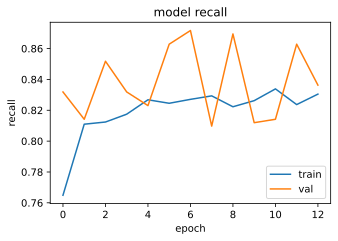

In [228]:
import keras
from matplotlib import pyplot as plt
# history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(trained_MobileNetV2.history['recall_3'])
plt.plot(trained_MobileNetV2.history['val_recall_3'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.subplots_adjust(bottom=.25, left=.25)
plt.show()

<b>finish [datagen]</b>

In [112]:
df_train["Diagnosis"].value_counts()

1    1752
0    1748
Name: Diagnosis, dtype: int64

In [113]:
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
img_list = []
for i in range (0,len(X_train_mobilenet)):
    brain_img =np.array(X_train_mobilenet)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    img_list.append(preprocess_input(img_arr))
X_train_mobilenet = np.array(img_list)

print(X_train_mobilenet.shape)

(3500, 128, 128, 3)


model

In [114]:
from keras.models import Sequential
from keras.layers import Dense , GlobalAveragePooling2D
from keras.applications import MobileNetV2
num_classes = 1
model = Sequential([
     MobileNetV2(input_shape=(224,224,3),weights="imagenet",include_top=False), 
     GlobalAveragePooling2D(),
     Dense(num_classes, activation='sigmoid',name='preds'),
])
model.layers[0].trainable= False
# show model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
preds (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [115]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        verbose=1,
    )
]

In [116]:
model.compile(optimizer='adam',
             loss=keras.losses.binary_crossentropy,
             metrics=['accuracy'])
model.fit(X_train_mobilenet,
          y_train_mobilenet,
          epochs=20,
          validation_split=0.2,
          verbose=1
         )

Epoch 1/20
88/88 [==============================] - 38s 435ms/step - loss: 0.6040 - accuracy: 0.6907 - val_loss: 0.4574 - val_accuracy: 0.7886
Epoch 2/20
88/88 [==============================] - 37s 426ms/step - loss: 0.4549 - accuracy: 0.7993 - val_loss: 0.4311 - val_accuracy: 0.8129
Epoch 3/20
88/88 [==============================] - 38s 432ms/step - loss: 0.4159 - accuracy: 0.8246 - val_loss: 0.4281 - val_accuracy: 0.8071
Epoch 4/20
88/88 [==============================] - 38s 429ms/step - loss: 0.3947 - accuracy: 0.8343 - val_loss: 0.4141 - val_accuracy: 0.8157
Epoch 5/20
88/88 [==============================] - 37s 425ms/step - loss: 0.3818 - accuracy: 0.8332 - val_loss: 0.4095 - val_accuracy: 0.8214
Epoch 6/20
88/88 [==============================] - 38s 433ms/step - loss: 0.3638 - accuracy: 0.8486 - val_loss: 0.4166 - val_accuracy: 0.8057
Epoch 7/20
88/88 [==============================] - 38s 429ms/step - loss: 0.3554 - accuracy: 0.8536 - val_loss: 0.4097 - val_accuracy: 0.8200

test

In [117]:
X_test_mobilenet=df_test['Pathes'].map(lambda x:np.asarray(open(x).resize((128,128))))

In [118]:
y_test_mobilenet=np.array(df_test['Diagnosis'])

In [119]:
img_list = []
for i in range (0,len(X_test_mobilenet)):
    brain_img =np.array(X_test_mobilenet)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    img_list.append(preprocess_input(img_arr))
X_test_mobilenet = np.array(img_list)
print(X_test_mobilenet.shape)

(1500, 128, 128, 3)


In [120]:
eval_score = model.evaluate(X_test_mobilenet,y_test_mobilenet)
print('The loss of the evaluation :'+' '+str(eval_score[0]*100))
print('The accuracy of the evaluation :'+' '+str(eval_score[1]*100))

47/47 [==============================] - 16s 338ms/step - loss: 0.4494 - accuracy: 0.8067
The loss of the evaluation : 44.93723809719086
The accuracy of the evaluation : 80.66666722297668


In [121]:
from sklearn.metrics import classification_report , confusion_matrix
# y_pred = model.predict_classes(X_test_mobilenet)


In [122]:
from sklearn.metrics import accuracy_score,f1_score
accuracy_score(y_test_mobilenet,y_pred)

0.8066666666666666

In [123]:
print(classification_report(y_test_mobilenet,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       752
           1       0.82      0.79      0.80       748

    accuracy                           0.81      1500
   macro avg       0.81      0.81      0.81      1500
weighted avg       0.81      0.81      0.81      1500



saving weights and model

In [126]:
# model_json = model.to_json()
# with open("mobilenetV2_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("mobilenetv2_weight.h5")
# print("Saved model to disk")

ValueError: bad mode 'w'

In [129]:
model.save("mobilenetV2.h5")

<h1>Inception Resnet V2</h1>

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import Sequence, to_categorical
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

import matplotlib.pyplot as plt
import PIL
import cv2
import tensorflow as tf
import pandas as pd
# import imgaug as ia
import numpy as np

# from imgaug import augmenters as iaa

from PIL import Image, ImageOps
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score

%config InlineBackend.figure_format="svg"
%matplotlib inline

In [ ]:
df=pd.read_csv('dataset.csv')

In [ ]:
df.shape

In [ ]:
df.head(n=2)

In [ ]:
df=df.drop(labels='Unnamed: 0',axis=1)

In [ ]:
df["Diagnosis"].value_counts()

In [ ]:
df.shape

In [15]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [ ]:
df_train,df_validate=train_test_split(df_train, test_size=0.15,random_state=8)

In [135]:
IMAGE_SIZE    = (299, 299)
NUM_CLASSES   = 2
BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 20

In [136]:
df_train.shape

(3500, 3)

In [137]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [138]:
train_batches = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import Sequence, to_categorical
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

import matplotlib.pyplot as plt
import PIL
import cv2
import tensorflow as tf
import pandas as pd
# import imgaug as ia
import numpy as np

# from imgaug import augmenters as iaa

from PIL import Image, ImageOps
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score

Found 3500 validated image filenames.


In [139]:

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
valid_batches = valid_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 1500 validated image filenames.


In [140]:
net = InceptionResNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))


In [141]:
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)


In [142]:
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True


In [30]:
from tensorflow.keras.optimizers import Adam
net_final.compile(
                  optimizer=Adam(lr=1e-2),
                  loss='binary_crossentropy', 
                  metrics=['accuracy']
                 )

NameError: name 'net_final' is not defined

In [144]:
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

Epoch 1/20
437/437 [==============================] - 4276s 10s/step - loss: 7.6529 - accuracy: 0.4991 - val_loss: 7.6686 - val_accuracy: 0.5000
Epoch 2/20
420/437 [===========================>..] - ETA: 2:28 - loss: 7.6686 - accuracy: 0.4994

KeyboardInterrupt: 

In [ ]:
model_json = net_final.to_json()
with open("inception_resnet_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("inception_resnet_weight.h5")
print("Saved model to disk")

<h1>Inception Resnet V2 [Transfer Learning]</h1>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import os
import sys
from glob import glob
import cv2 
import time
import datetime

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam, Adamax
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
IMAGE_SIZE_INCEPTION = (75,75)
BATCH_SIZE = 64
NUM_CLASSES = 2

In [24]:
# model_inception = InceptionResNetV2(
#         input_shape = (IMAGE_SIZE_INCEPTION[0],IMAGE_SIZE_INCEPTION[1],3) ,
#         weights = 'imagenet',
#         include_top = False,
#         pooling='max'

# )
# model_inception.trainable = False

# x = Flatten()(model_inception.output)
# x = Dense(NUM_CLASSES, activation = 'softmax')(x)

# model1 = Model(inputs = model_inception.input , outputs = x)


# # # #
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
model_inception = InceptionResNetV2(
        input_shape = (IMAGE_SIZE_INCEPTION[0],IMAGE_SIZE_INCEPTION[1],3) ,
        weights = 'imagenet',
        include_top = False,
        pooling='max'
)
x=model_inception.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(NUM_CLASSES-1, activation='sigmoid')(x)
model=Model(inputs=model_inception.input, outputs=output)
model.compile(Adamax(lr=.01), loss='binary_crossentropy', metrics=['accuracy',metrics.Precision(),metrics.Recall(),metrics.TruePositives(),metrics.TrueNegatives(),metrics.FalsePositives(),metrics.FalseNegatives()]) 

In [31]:
model1.summary()

NameError: name 'model1' is not defined

In [27]:
def scalar(img):
    return img/127.5-1

In [28]:
train_datagen = ImageDataGenerator(
    
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
#         shear_range=0.2,
        zoom_range=0.2,
#         channel_shift_range=10,
    
        horizontal_flip=True,
        vertical_flip = True,
#         fill_mode='nearest',
        preprocessing_function = scalar
)

In [29]:
train_batch = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE_INCEPTION,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

Found 7000 validated image filenames.


In [30]:
valid_datagen = ImageDataGenerator(preprocessing_function=scalar,
                                   
                                   rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
#                                    shear_range=0.2,
                                   zoom_range=0.2,
#                                    channel_shift_range=10,
                                   
                                   horizontal_flip=True,
                                   vertical_flip=True
#                                    fill_mode='nearest'
                                  )


In [31]:
valid_batches = valid_datagen.flow_from_dataframe(dataframe=df_evaluate,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE_INCEPTION,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 900 validated image filenames.


In [32]:
test_batches = valid_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE_INCEPTION,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 2100 validated image filenames.


In [174]:
df_test["Diagnosis"].value_counts()

0    1091
1    1009
Name: Diagnosis, dtype: int64

In [175]:
# model1.compile(
#     Adamax(lr=.001),
#     loss = 'binary_crossentropy' , 
# #     optimizer = 'adam' , 
#     metrics = ['accuracy']
# )

In [176]:
# callbacks = [
#     keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
# #         monitor="val_loss",
#         monitor="val_loss",
#         # "no longer improving" being defined as "no better than 1e-2 less"
#         min_delta=1e-3,
#         # "no longer improving" being further defined as "for at least 2 epochs"
#         patience=5,
#         verbose=1,
#     )
# ]

In [33]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
#         print_in_color (msgs, (244, 252, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration', 'Batch')
#         print_in_color(msg, (244,252,3), (55,65,80)) 
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:60s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
#         print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
#             print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [178]:
# net1 = model1.fit(
#         train_batch,
#         validation_data = valid_batches,
#         epochs = 100,
#         callbacks = [callbacks]
# )


In [34]:
model_name = "InceptionResnetV2"
batch_size=64
train_steps = int(len(train_batch.labels)/batch_size)
epochs =50
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=False # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model

callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze,batches=train_steps, initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing

In [180]:
model1=model.fit(
    x=train_batch,  
    epochs=epochs, 
    verbose=2, 
    callbacks=callbacks,  
    validation_data=valid_batches,
#     validation_split=0.1,
    validation_steps=None,  
    shuffle=False,  
    initial_epoch=0
)

Epoch 1/50
110/110 - 728s - loss: 3.6105 - accuracy: 0.7783 - precision_3: 0.7833 - recall_2: 0.7762 - true_positives_5: 2747.0000 - true_negatives_4: 2701.0000 - false_positives_4: 760.0000 - false_negatives_4: 792.0000 - val_loss: 1385.6200 - val_accuracy: 0.5867 - val_precision_3: 0.7667 - val_recall_2: 0.2544 - val_true_positives_5: 115.0000 - val_true_negatives_4: 413.0000 - val_false_positives_4: 35.0000 - val_false_negatives_4: 337.0000
Epoch 2/50
110/110 - 722s - loss: 0.6030 - accuracy: 0.8113 - precision_3: 0.8105 - recall_2: 0.8180 - true_positives_5: 2895.0000 - true_negatives_4: 2784.0000 - false_positives_4: 677.0000 - false_negatives_4: 644.0000 - val_loss: 2.5609 - val_accuracy: 0.8400 - val_precision_3: 0.8392 - val_recall_2: 0.8429 - val_true_positives_5: 381.0000 - val_true_negatives_4: 375.0000 - val_false_positives_4: 73.0000 - val_false_negatives_4: 71.0000
Epoch 3/50
110/110 - 721s - loss: 0.5181 - accuracy: 0.8217 - precision_3: 0.8204 - recall_2: 0.8288 - true_

In [182]:
model.save("InceptionResnetV2_ten.h5")

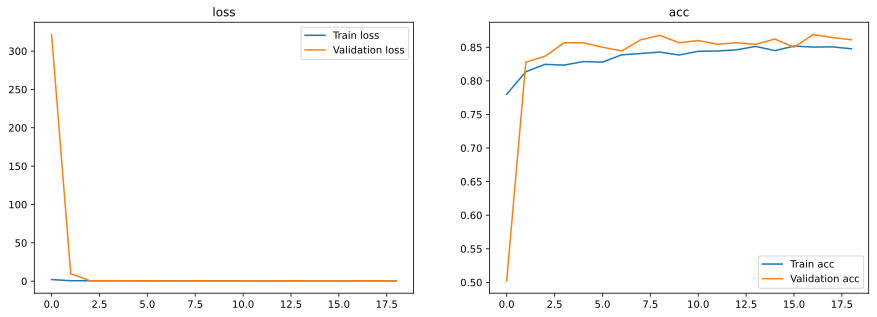

In [71]:
plot_acc_loss(model1)

In [43]:
model=load_model("InceptionResnetV2_ten.h5")

In [44]:
from sklearn.metrics import classification_report , confusion_matrix
y_pred_inception_resnet=model.evaluate(test_batches)

33/33 [==============================] - 19s 573ms/step - loss: 0.4422 - accuracy: 0.8605 - precision_3: 0.8469 - recall_2: 0.8662 - true_positives_5: 874.0000 - true_negatives_4: 933.0000 - false_positives_4: 158.0000 - false_negatives_4: 135.0000


<AxesSubplot:>

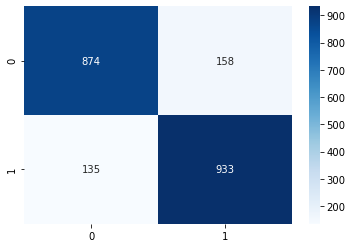

In [45]:
import seaborn as sns

# cf_matrix = np.array([[50, 2, 38],
#                       [7, 43, 32],
#                       [9,  4, 76]])

sns.heatmap(np.array([[874,158],[135,933]]), annot=True, cmap='Blues', fmt='d')

In [40]:
y_pred_inception_resnet

[0.38415268063545227,
 0.8642857074737549,
 0.8555992245674133,
 0.8632309436798096,
 871.0,
 944.0,
 147.0,
 138.0]

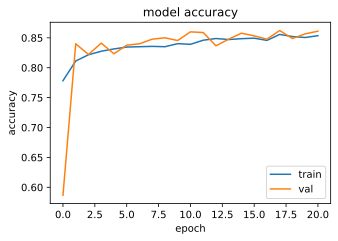

In [183]:
import keras
from matplotlib import pyplot as plt
# history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.subplots_adjust(bottom=.25, left=.25)
plt.show()

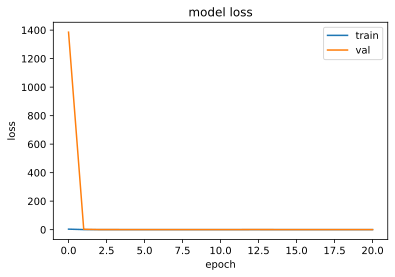

In [184]:
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [185]:
print(model1.history.keys())

dict_keys(['loss', 'accuracy', 'precision_3', 'recall_2', 'true_positives_5', 'true_negatives_4', 'false_positives_4', 'false_negatives_4', 'val_loss', 'val_accuracy', 'val_precision_3', 'val_recall_2', 'val_true_positives_5', 'val_true_negatives_4', 'val_false_positives_4', 'val_false_negatives_4'])


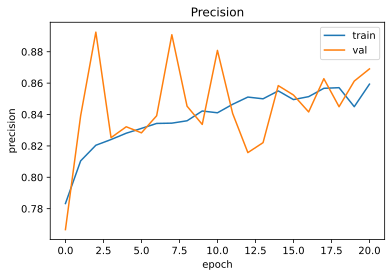

In [191]:
plt.plot(model1.history['precision_3'])
plt.plot(model1.history['val_precision_3'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

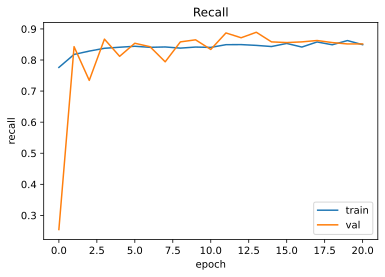

In [193]:
plt.plot(model1.history['recall_2'])
plt.plot(model1.history['val_recall_2'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [65]:
y_pred_inception_resnet = model.predict(test_batches,verbose=2)
# predicted_categories_inception_resnet = np.argmax(y_pred_inception_resnet, axis = 1)


33/33 - 19s


In [ ]:
true_categories = tf.concat([y for x, y in test_batches], axis = 0).numpy()

In [ ]:
true_categories_argmax = np.argmax(true_categories, axis = 1)

In [ ]:
print(classification_report(true_categories_argmax, predicted_categories))

In [112]:
# print(np.argmax(y_pred_inception_resnet,axis=1))

In [121]:
# print(classification_report(y_pred_inception_resnet,np.array(df_test["Diagnosis"])))

print(classification_report(np.argmax(y_pred_inception_resnet,axis=1),np.array(df_test["Diagnosis"])))

AxisError: axis 1 is out of bounds for array of dimension 1

In [108]:
def print_info( test_gen, preds, print_code, save_dir = None, subject = None ):
    class_dict=test_gen.class_indices
#     class_dict=valid_datagen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    
    
#     dict_name= subject + '-' +str(len(classes)) +'.txt'  
#     dict_path=os.path.join(save_dir,dict_name)    
#     with open(dict_path, 'w') as x_file:
#         x_file.write(dict_as_text)    
    
    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

In [109]:
valid_batches.class_indices

AttributeError: 'DataFrameIterator' object has no attribute 'class_indices'

In [110]:
# print_info( train_batch, y_pred_inception_resnet, print_code, save_dir, subject )
print_info( test_batches, y_pred_inception_resnet, 0) #, save_dir, subject )

KeyError: 0

In [19]:
import keras
from matplotlib import pyplot as plt
plt.plot(model.history['acc'])
plt.plot(model.history['val_acc'])

TypeError: 'NoneType' object is not subscriptable

<h1>MLPClassifier</h1>

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import glob,os

In [3]:
df_train = pd.read_csv('df_train.csv')

In [4]:
df_train=df_train.drop(labels='Unnamed: 0',axis=1)

In [5]:
df_train.head(n=2)

,Patient ID,Diagnosis,Pathes
0,13691,1,archive/13691/1/13691_idx5_x3201_y1301_class1.png
1,12749,1,archive/12749/1/12749_idx5_x2601_y601_class1.png


In [6]:
# df_test = pd.read_csv('df_test.csv')

In [7]:
# df_test=df_test.drop(labels='Unnamed: 0',axis=1)

In [6]:
# df_test.head(n=2)

In [7]:
from PIL import Image
# random_train['Pixels']=np.array(random_train['Pathes'].map(lambda x:np.asarray(open(x).resize((128,128)))))
# random_train['Pixels']=random_train.loc[:,['Pathes']].map(lambda x:np.asarray(open(x).resize((128,128))))
X_train_MLP=df_train['Pathes'].map(lambda x:np.asarray(Image.open(x).resize((50,50))))


In [8]:
X_train_MLP.shape

(7000,)

In [9]:
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
img_list = []
for i in range (0,len(X_train_MLP)):
    brain_img =np.array(X_train_MLP)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    img_list.append(preprocess_input(img_arr))
X_scaled = np.array(img_list)

print(X_scaled.shape)

(7000, 50, 50, 3)


In [10]:
X_scaled[0].shape

(50, 50, 3)

In [11]:
X_train_shape = X_scaled.shape[1]*X_scaled.shape[2]*X_scaled.shape[3]
X_Flatten = X_scaled.reshape(X_scaled.shape[0],X_train_shape)

In [12]:
X_Flatten.shape

(7000, 7500)

In [13]:
df_test=pd.read_csv("df_test_st.csv")
df_test=df_test.drop(labels='Unnamed: 0',axis=1)

In [14]:
X_test_MLP=df_test["Pathes"].map(lambda x:np.asarray(Image.open(x).resize((50,50))))

In [15]:
image_list = []
for i in range (0,len(X_test_MLP)):
    brain_img =np.array(X_test_MLP)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    image_list.append(preprocess_input(img_arr))
X_scaled_test = np.array(image_list)

print(X_scaled_test.shape)

(3000, 50, 50, 3)


In [16]:
X_test_shape = X_scaled_test.shape[1]*X_scaled.shape[2]*X_scaled.shape[3]
X_Flatten_test = X_scaled_test.reshape(X_scaled_test.shape[0],X_test_shape)

In [17]:
X_Flatten_test.shape

(3000, 7500)

<b>searching parameters</b>

In [23]:
from sklearn.model_selection import GridSearchCV
param_grid={
    'hidden_layer_sizes':[(100,100,100,100),(50,100,50),(100,100)],
    'learning_rate_init':[0.001],
    'activation':['logistic'],
    'solver':['adam','sgd'],
    'batch_size' : [32, 64],
    'alpha' : [0.0001],
    'learning_rate' : ['constant','adaptive']
}

gs=GridSearchCV(
    estimator=MLPClassifier(
        early_stopping=True
    ),
    param_grid=param_grid,
    cv=4,
    verbose=3,
    n_jobs=-1
)
history_MLP=gs.fit(X_Flatten,np.array(df_train["Diagnosis"]))

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 103.7min finished


In [25]:
gs.best_params_

{'activation': 'logistic',
 'alpha': 0.0001,
 'batch_size': 64,
 'hidden_layer_sizes': (100, 100),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'solver': 'adam'}

In [68]:
clf=MLPClassifier(hidden_layer_sizes=(100,100),alpha=0.0001,learning_rate='constant',activation='logistic',max_iter=400,verbose=2,early_stopping=True)
history_MLP=clf.fit(X_Flatten,np.array(df_train["Diagnosis"]))


Iteration 1, loss = 0.62757355
Validation score: 0.750000
Iteration 2, loss = 0.50849072
Validation score: 0.804286
Iteration 3, loss = 0.48079979
Validation score: 0.795714
Iteration 4, loss = 0.46167738
Validation score: 0.805714
Iteration 5, loss = 0.45388827
Validation score: 0.804286
Iteration 6, loss = 0.44356915
Validation score: 0.807143
Iteration 7, loss = 0.46184820
Validation score: 0.807143
Iteration 8, loss = 0.43661674
Validation score: 0.810000
Iteration 9, loss = 0.43253806
Validation score: 0.802857
Iteration 10, loss = 0.41637212
Validation score: 0.800000
Iteration 11, loss = 0.40454283
Validation score: 0.800000
Iteration 12, loss = 0.40022777
Validation score: 0.797143
Iteration 13, loss = 0.39381215
Validation score: 0.791429
Iteration 14, loss = 0.36896335
Validation score: 0.787143
Iteration 15, loss = 0.34115600
Validation score: 0.758571
Iteration 16, loss = 0.33328992
Validation score: 0.760000
Iteration 17, loss = 0.31507802
Validation score: 0.788571
Iterat

In [69]:
y_pred_MLP=clf.predict(X_Flatten_test)

In [77]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print(accuracy_score(y_pred_MLP, np.array(df_test["Diagnosis"])))
print(recall_score(y_pred_MLP, np.array(df_test["Diagnosis"])))
print(precision_score(y_pred_MLP, np.array(df_test["Diagnosis"])))
print(f1_score(y_pred_MLP, np.array(df_test["Diagnosis"])))

0.7813333333333333
0.8108108108108109
0.7186858316221766
0.7619738751814223


In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_MLP, np.array(df_test["Diagnosis"])))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1705
           1       0.72      0.81      0.76      1295

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.79      0.78      0.78      3000



In [79]:
history_MLP

MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(100, 100), max_iter=400, verbose=2)

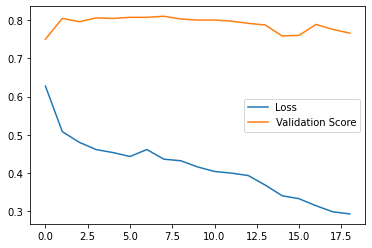

In [80]:
plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)
plt.legend(["Loss", "Validation Score"], loc ="right")


<AxesSubplot:>

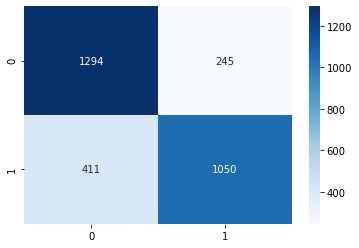

In [81]:
import seaborn as sns
sns.heatmap(np.array(confusion_matrix(np.array(df_test["Diagnosis"]),y_pred_MLP)),annot=True, cmap='Blues', fmt='d')

<h1>Support Vector Machine</h1>

In [18]:
df_train.head(n=2)

,Patient ID,Diagnosis,Pathes
0,13691,1,archive/13691/1/13691_idx5_x3201_y1301_class1.png
1,12749,1,archive/12749/1/12749_idx5_x2601_y601_class1.png


<b>Flatten image</b>

In [19]:
X_train_SVM=df_train['Pathes'].map(lambda x:np.asarray(Image.open(x).resize((50,50))))

In [20]:
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
img_list = []
for i in range (0,len(X_train_SVM)):
    brain_img =np.array(X_train_SVM)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    img_list.append(preprocess_input(img_arr))
X_scaled = np.array(img_list)

print(X_scaled.shape)

(7000, 50, 50, 3)


In [21]:
X_train_shape_SVM = X_scaled.shape[1]*X_scaled.shape[2]*X_scaled.shape[3]
X_Flatten_SVM = X_scaled.reshape(X_scaled.shape[0],X_train_shape_SVM)

In [22]:
X_Flatten_SVM.shape

(7000, 7500)

In [23]:
df_test=pd.read_csv("df_test_st.csv")
df_test=df_test.drop(labels='Unnamed: 0',axis=1)

In [24]:
X_test_SVM=df_test['Pathes'].map(lambda x:np.asarray(Image.open(x).resize((50,50))))

In [25]:
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
img_list = []
for i in range (0,len(X_test_SVM)):
    brain_img =np.array(X_test_SVM)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    img_list.append(preprocess_input(img_arr))
X_scaled = np.array(img_list)

print(X_scaled.shape)

(3000, 50, 50, 3)


In [26]:
X_test_shape_SVM = X_scaled.shape[1]*X_scaled.shape[2]*X_scaled.shape[3]
X_Flatten_SVM_test = X_scaled.reshape(X_scaled.shape[0],X_train_shape_SVM)

In [27]:
X_Flatten_SVM_test.shape

(3000, 7500)

parameter selection

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
param_grid={
    'C':[1,10,100,1000],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[1,2,3],
}


In [33]:
from sklearn.svm import SVC
gs=GridSearchCV(
    estimator=SVC(
        max_iter=50
    ),
    param_grid=param_grid,
    cv=4,
    verbose=2,
    n_jobs=-1
)

In [95]:
gs.fit(X_Flatten_SVM,np.array(df_train["Diagnosis"]))

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 12.1min finished
/home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


GridSearchCV(cv=4, estimator=SVC(max_iter=50), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'degree': [1, 2, 3],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=2)

In [97]:
gs.best_params_

{'C': 100, 'degree': 1, 'kernel': 'rbf'}

In [34]:
model_SVC = SVC(C=100,kernel='rbf',degree=1)

In [35]:
z=model_SVC.fit(X_Flatten_SVM,np.array(df_train["Diagnosis"]))

In [36]:
prediction = model_SVC.predict(X_Flatten_SVM_test)

In [39]:
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score,f1_score

In [38]:
print(classification_report(prediction,np.array(df_test["Diagnosis"])))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1569
           1       0.78      0.79      0.78      1431

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



In [41]:
print(accuracy_score(prediction,np.array(df_test["Diagnosis"])))

0.7913333333333333


In [42]:
print(recall_score(prediction,np.array(df_test["Diagnosis"])))

0.7917540181691125


In [43]:
print(precision_score(prediction,np.array(df_test["Diagnosis"])))

0.7754962354551677


In [44]:
print(f1_score(prediction,np.array(df_test["Diagnosis"])))

0.7835408022130014


<AxesSubplot:>

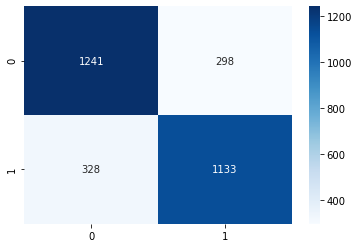

In [45]:
import seaborn as sns
sns.heatmap(np.array(confusion_matrix(np.array(df_test["Diagnosis"]),prediction)),annot=True, cmap='Blues', fmt='d')

In [46]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

In [47]:
estimator = SVC(C=100,kernel='rbf',degree=1)

In [ ]:
plot_learning_curve(estimator, "Learning rate for SVM classifier", X_Flatten_SVM, np.array(df_train["Diagnosis"]),(0.5,1), 10)

<h1>Hybrid Model [SVM+VGG16]</h1>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models

In [2]:
# def vgg16(weights_path=None):
#     model = models.Sequential()
    
#     model.add(layers.ZeroPadding2D((1,1),input_shape=(224,224,3)))
#     model.add(layers.Convolution2D(64,(3,3),activation='relu'))
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(64,(3,3),activation='relu'))
#     model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
#     model.add(layers.ZeroPadding2D((1,1)))
#     model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    
#     model.add(layers.Flatten())
    
#     model.add(layers.Dense(4096,activation='relu'))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(4096,activation='relu'))
#     model.add(layers.Dropout(0.5))
    
# #     model.add(layers.Dense(1000,activation='softmax'))
    
#     model.add(layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear'))
    
#     if weights_path:
#         model.load_weights(weights_path)
#     return model
    

In [3]:
from keras.applications.vgg16 import VGG16

In [4]:
SIZE=50

In [5]:
model_vgg16=VGG16(weights=None, include_top=False, input_shape=(SIZE, SIZE, 3))

In [6]:
for layer in model_vgg16.layers:
    layer.trainable = False

In [10]:
df_train = pd.read_csv("df_train.csv")
df_train=df_train.drop(labels='Unnamed: 0',axis=1)

In [11]:
df_test = pd.read_csv("df_test_st.csv")
df_test=df_test.drop(labels='Unnamed: 0',axis=1)

In [12]:
df_train.head(n=2)

,Patient ID,Diagnosis,Pathes
0,13691,1,archive/13691/1/13691_idx5_x3201_y1301_class1.png
1,12749,1,archive/12749/1/12749_idx5_x2601_y601_class1.png


In [13]:
df_test.head(n=2)

,Patient ID,Diagnosis,Pathes
0,9254,0,archive/9254/0/9254_idx5_x1051_y1051_class0.png
1,14210,0,archive/14210/0/14210_idx5_x1301_y101_class0.png


In [14]:
# from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
# # from tensorflow.python.keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.applications.vgg16 import preprocess_input
# train_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=90,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )
X_train_vgg16 = df_train['Pathes'].map(lambda x:np.asarray(Image.open(x).resize((50,50))))


In [15]:
X_train_vgg16.shape

(7000,)

In [16]:
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
img_list = []
for i in range (0,len(X_train_vgg16)):
    brain_img =np.array(X_train_vgg16)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    img_list.append(preprocess_input(img_arr))
X_scaled = np.array(img_list)

print(X_scaled.shape)

(7000, 50, 50, 3)


In [17]:
# BATCH_SIZE = 64
# IMAGE_SIZE = (224,224)
# train_batches = train_datagen.flow_from_dataframe(dataframe=df_train,
#                                                   directory=None,
#                                                   x_col="Pathes",
#                                                   y_col="Diagnosis",
#                                                   target_size=IMAGE_SIZE,
#                                                   interpolation='bicubic',
#                                                   class_mode='raw',
#                                                   shuffle=True,
#                                                   batch_size=BATCH_SIZE)



In [18]:
features = model_vgg16.predict(X_scaled,verbose=1)

219/219 [==============================] - 84s 385ms/step


In [19]:
features.shape

(7000, 1, 1, 512)

In [48]:
features[0]

array([[[3.0507154e+00, 0.0000000e+00, 1.6426598e+01, 2.6115606e+01,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 5.4891686e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 3.0651203e+01, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 2.7457006e+01, 1.1769354e-01, 2.3528545e+01,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.4112947e+01,
         0.0000000e+00, 0.0000000e

In [20]:
trainable_features = features.reshape(features.shape[0], -1)

In [21]:
trainable_features.shape

(7000, 512)

In [22]:
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    rotation_range=90,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    channel_shift_range=10,
#                                    horizontal_flip=True,
#                                    )
# test_batches = test_datagen.flow_from_dataframe(dataframe=df_test,
#                                                   directory=None,
#                                                   x_col="Pathes",
#                                                   y_col="Diagnosis",
#                                                   target_size=IMAGE_SIZE,
#                                                   interpolation='bicubic',
#                                                   class_mode='raw',
#                                                   shuffle=False,
#                                                   batch_size=BATCH_SIZE)
X_test_vgg16 = df_test['Pathes'].map(lambda x:np.asarray(Image.open(x).resize((50,50))))

In [23]:
# valid_batches = test_datagen.flow_from_dataframe(dataframe=df_evaluate,
#                                                   directory=None,
#                                                   x_col="Pathes",
#                                                   y_col="Diagnosis",
#                                                   target_size=IMAGE_SIZE,
#                                                   interpolation='bicubic',
#                                                   class_mode='raw',
#                                                   shuffle=False,
#                                                   batch_size=BATCH_SIZE)
X_test_vgg16.shape

(3000,)

In [24]:
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
img_list = []
for i in range (0,len(X_test_vgg16)):
    brain_img =np.array(X_test_vgg16)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    img_list.append(preprocess_input(img_arr))
X_scaled = np.array(img_list)

print(X_scaled.shape)

(3000, 50, 50, 3)


In [25]:
features = model_vgg16.predict(X_scaled,verbose=1)

94/94 [==============================] - 35s 371ms/step


In [26]:
features.shape

(3000, 1, 1, 512)

In [27]:
testing_features =  features.reshape(features.shape[0], -1)

In [28]:
testing_features.shape

(3000, 512)

<b>SVM on extracted features</b>

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
x_train_scaled = scaler.fit_transform(trainable_features)
x_test_scaled = scaler.transform(testing_features)

In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
param_grid={
    'C':[1,10,100,1000],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[1,2,3],
}

In [32]:
from sklearn.svm import SVC
gs=GridSearchCV(
    estimator=SVC(
        max_iter=50
    ),
    param_grid=param_grid,
    cv=4,
    verbose=2,
    n_jobs=-1
)

In [33]:
history = gs.fit(x_train_scaled,np.array(df_train["Diagnosis"]))

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   40.6s finished
/home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [34]:
gs.best_estimator_

SVC(C=1, degree=1, max_iter=50)

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


clf_vgg16_svm = make_pipeline(StandardScaler(), SVC())
clf_vgg16_svm.fit(trainable_features,np.array(df_train["Diagnosis"]))
y_pred_vgg16_svm = clf_vgg16_svm.predict(testing_features)
# print("Accuracy: ", accuracy_score(ytest, y_pred))

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_vgg16_svm,np.array(df_test["Diagnosis"])))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1521
           1       0.82      0.81      0.81      1479

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



In [42]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score

In [43]:
accuracy_score(y_pred_vgg16_svm,np.array(df_test["Diagnosis"]))

0.8153333333333334

In [44]:
recall_score(y_pred_vgg16_svm,np.array(df_test["Diagnosis"]))

0.8066260987153482

In [45]:
precision_score(y_pred_vgg16_svm,np.array(df_test["Diagnosis"]))

0.8165639972621492

In [46]:
f1_score(y_pred_vgg16_svm,np.array(df_test["Diagnosis"]))

0.8115646258503402

<AxesSubplot:>

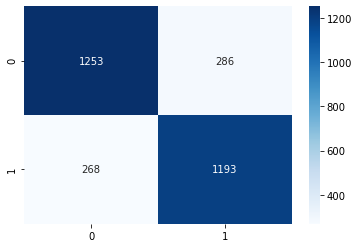

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(np.array(confusion_matrix(np.array(df_test["Diagnosis"]),y_pred_vgg16_svm)),annot=True, cmap='Blues', fmt='d')

In [48]:
# feature_SVM = SVC(C=100,degree=1)

In [49]:
# history = feature_SVM.fit(trainable_features,np.array(df_train["Diagnosis"]))

In [50]:
# y_pred_feature_SVM = feature_SVM.predict(testing_features)

In [51]:
# from sklearn.metrics import classification_report
# print(classification_report(y_pred_feature_SVM,np.array(df_test["Diagnosis"])))

In [52]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score

In [53]:
# precision_score(y_pred_feature_SVM,np.array(df_test["Diagnosis"]))

In [54]:
# recall_score(y_pred_feature_SVM,np.array(df_test["Diagnosis"]))

In [55]:
# f1_score(y_pred_feature_SVM,np.array(df_test["Diagnosis"]))

In [56]:
# accuracy_score(y_pred_feature_SVM,np.array(df_test["Diagnosis"]))

In [96]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# sns.heatmap(np.array(confusion_matrix(np.array(df_test["Diagnosis"]),y_pred_feature_SVM)),annot=True, cmap='Blues', fmt='d')

In [116]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/matplotlib/pyplot.py'>

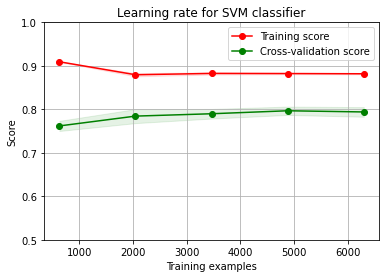

In [117]:
plot_learning_curve(clf_vgg16_svm, "Learning rate for SVM classifier", trainable_features, np.array(df_train["Diagnosis"]),(0.5,1), 10)

<b>RandomForestClassifier on extracted features</b>

In [57]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=201, max_depth=None, min_samples_split=2, random_state=0)


In [58]:
RF_model.fit(trainable_features,np.array(df_train["Diagnosis"]))

RandomForestClassifier(n_estimators=201, random_state=0)

In [59]:
prediction_RF = RF_model.predict(testing_features)

In [60]:
print(classification_report(prediction_RF,np.array(df_test["Diagnosis"])))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1569
           1       0.79      0.81      0.80      1431

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



In [61]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score

In [62]:
precision_score(prediction_RF,np.array(df_test["Diagnosis"]))

0.7905544147843943

In [63]:
recall_score(prediction_RF,np.array(df_test["Diagnosis"]))

0.8071278825995807

In [64]:
f1_score(prediction_RF,np.array(df_test["Diagnosis"]))

0.7987551867219916

In [65]:
accuracy_score(prediction_RF,np.array(df_test["Diagnosis"]))

0.806

<AxesSubplot:>

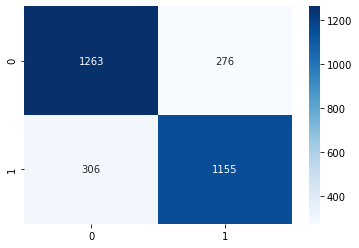

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(np.array(confusion_matrix(np.array(df_test["Diagnosis"]),prediction_RF)),annot=True, cmap='Blues', fmt='d')

<b>logistic regression on extracted features</b>

In [67]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
classifier.fit(trainable_features,np.array(df_train["Diagnosis"]))


/home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [68]:
y_pred_logistic_reg = classifier.predict(testing_features)

In [69]:
print(classification_report(y_pred_logistic_reg,np.array(df_test["Diagnosis"])))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1615
           1       0.77      0.82      0.79      1385

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000



<AxesSubplot:>

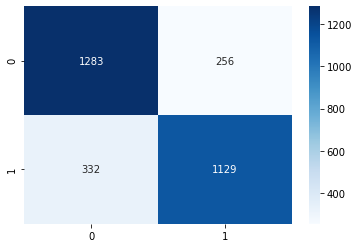

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(np.array(confusion_matrix(np.array(df_test["Diagnosis"]),y_pred_logistic_reg)),annot=True, cmap='Blues', fmt='d')

In [71]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score

In [72]:
accuracy_score(y_pred_logistic_reg,np.array(df_test["Diagnosis"]))

0.804

In [73]:
precision_score(y_pred_logistic_reg,np.array(df_test["Diagnosis"]))

0.7727583846680356

In [74]:
recall_score(y_pred_logistic_reg,np.array(df_test["Diagnosis"]))

0.8151624548736462

In [75]:
f1_score(y_pred_logistic_reg,np.array(df_test["Diagnosis"]))

0.7933942375263527

<b>Adaboost classifier on extracted features</b>

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

clf_adaboost = AdaBoostClassifier(n_estimators=51)
scores = cross_val_score(clf_adaboost, trainable_features, np.array(df_train["Diagnosis"]), cv=5)
scores.mean()

0.7812857142857144

In [77]:
clf_adaboost.fit(trainable_features,np.array(df_train["Diagnosis"]))

AdaBoostClassifier(n_estimators=51)

In [78]:
y_adaboost_pred=clf_adaboost.predict(testing_features)

In [79]:
print(classification_report(y_adaboost_pred,np.array(df_test["Diagnosis"])))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1504
           1       0.80      0.78      0.79      1496

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



In [80]:
accuracy_score(y_adaboost_pred,np.array(df_test["Diagnosis"]))

0.7936666666666666

In [81]:
precision_score(y_adaboost_pred,np.array(df_test["Diagnosis"]))

0.8001368925393566

In [82]:
recall_score(y_adaboost_pred,np.array(df_test["Diagnosis"]))

0.7814171122994652

In [83]:
f1_score(y_adaboost_pred,np.array(df_test["Diagnosis"]))

0.7906662157592154

<AxesSubplot:>

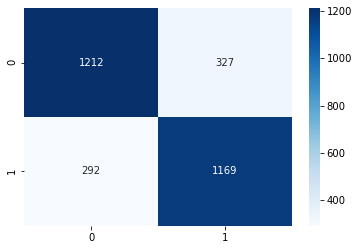

In [84]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(np.array(confusion_matrix(np.array(df_test["Diagnosis"]),y_adaboost_pred)),annot=True, cmap='Blues', fmt='d')